In [1]:
# Get pointings
# For each pointing, get the sky loss given:
# a dish model (beam with aperture effects)
# a ionosphere model, and
# a bright source model (D point sources)
# an array

# Sky loss calculation:
# Choose M random l,m within the field of view
# For each frequency:
#   For each bright source:
#     compute model vis
#     accumulate visibilities
#   DFT vis only M directions
#   Compute RMS, with zero-point adjustment +1/(N-1)



Searching for sync certificate: /home/albert/git/DSA2000-Cal/dsa2000_cal/src/dsa2000_assets/arrays/dsa2000_optimal_v1/.sync_cert
Searching for sync certificate: /home/albert/git/DSA2000-Cal/dsa2000_cal/src/dsa2000_assets/arrays/dsa2000_optimal_v1/.sync_cert
Searching for sync certificate: /home/albert/git/DSA2000-Cal/dsa2000_cal/src/dsa2000_assets/beam_models/dsa2000/.sync_cert
Group: /
Group: /X_pol_Efields
Leaf: /X_pol_Efields/ephi | Shape: (3, 1801, 3601) | Dtype: complex128 | Min: (-132.812943-50.7980156j) | Max: (132.812943+50.7980156j)
Leaf: /X_pol_Efields/etheta | Shape: (3, 1801, 3601) | Dtype: complex128 | Min: (-132.812943-50.7980156j) | Max: (132.812943+50.7980156j)
Group: /Y_pol_Efields
Leaf: /Y_pol_Efields/ephi | Shape: (3, 1801, 3601) | Dtype: complex128 | Min: (-132.812943-50.7980156j) | Max: (132.812943+50.7980156j)
Leaf: /Y_pol_Efields/etheta | Shape: (3, 1801, 3601) | Dtype: complex128 | Min: (-132.812943-50.7980156j) | Max: (132.812943+50.7980156j)
Leaf: /freq_Hz | S

/home/albert/git/DSA2000-Cal/dsa2000_cal/src/dsa2000_common/gain_models/base_spherical_interpolator.py:219: RuntimeWarning: divide by zero encountered in log10
  10. * np.log10(np.abs(gain_screen.T)),


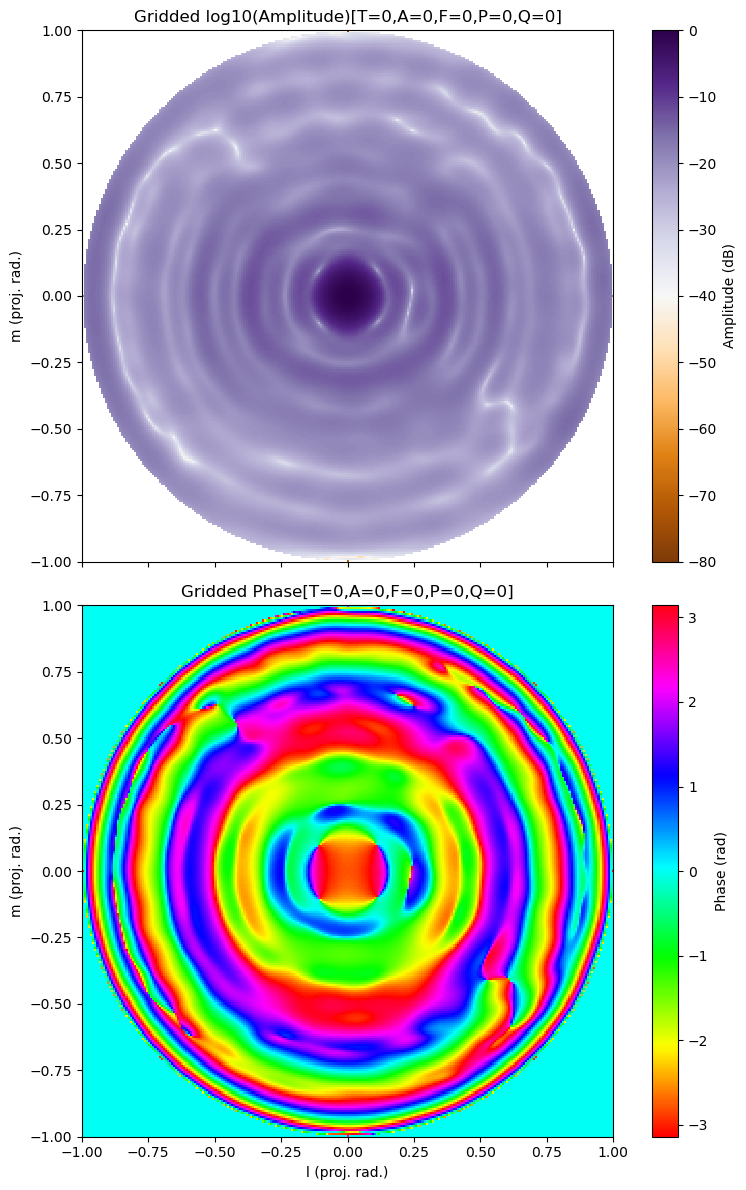

Searching for sync certificate: /home/albert/git/DSA2000-Cal/dsa2000_cal/src/dsa2000_assets/source_models/calibrators/.sync_cert
=== (dsa2000_common.geodesics.base_geodesic_model) compute_far_field_geodesics ===
In: ([t,...],[a,3,...],[t,3,...],[s,3,...]) Out: ([t,a,s,...])
vmap(t, in_axes=(0, None, 0, None), out_axes=0)  # -> In: ([...],[a,3,...],[3,...],[s,3,...]) Out: ([a,s,...])
vmap(a, in_axes=(None, 0, None, None), out_axes=0)  # -> In: ([...],[3,...],[3,...],[s,3,...]) Out: ([s,...])
vmap(s, in_axes=(None, None, None, 0), out_axes=0)  # -> In: ([...],[3,...],[3,...],[3,...]) Out: ([...])
Implied function signature :: (...),(3,...),(3,...),(3,...) -> (...)
=== (dsa2000_common.gain_models.base_spherical_interpolator) interp_model_gains ===
In: ([t,...],[t,a,s,...],[t,a,s,...],[f,...],[T,lres,mres,F,...]) Out: ([t,a,f,s,...])
vmap(t, in_axes=(0, 0, 0, None, None), out_axes=0)  # -> In: ([...],[a,s,...],[a,s,...],[f,...],[T,lres,mres,F,...]) Out: ([a,f,s,...])
vmap(a, in_axes=(None,

In [ ]:


import os

os.environ['JAX_PLATFORMS'] = 'cuda,cpu'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.0'
# os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"


import json
from functools import partial

import astropy.constants as const
import astropy.coordinates as ac
import astropy.time as at
import astropy.units as au
import jax.numpy as jnp
import jax.random
import numpy as np

from dsa2000_assets.content_registry import fill_registries
from dsa2000_common.common.ray_utils import TimerLog
from dsa2000_assets.registries import source_model_registry, array_registry
from dsa2000_common.common.array_types import FloatArray
from dsa2000_common.common.astropy_utils import create_spherical_spiral_grid, get_time_of_local_meridean
from dsa2000_common.common.noise import calc_image_noise
from dsa2000_common.common.quantity_utils import time_to_jnp, quantity_to_jnp
from dsa2000_common.common.serialise_utils import SerialisableBaseModel
from dsa2000_common.delay_models.base_far_field_delay_engine import build_far_field_delay_engine, \
    BaseFarFieldDelayEngine
from dsa2000_common.delay_models.base_near_field_delay_engine import build_near_field_delay_engine, \
    BaseNearFieldDelayEngine
from dsa2000_common.delay_models.uvw_utils import perley_lmn_from_icrs
from dsa2000_common.gain_models.beam_gain_model import build_beam_gain_model
from dsa2000_common.gain_models.gain_model import GainModel
from dsa2000_common.geodesics.base_geodesic_model import build_geodesic_model, BaseGeodesicModel
from dsa2000_common.visibility_model.source_models.celestial.base_point_source_model import \
    build_point_source_model_from_wsclean_components, BasePointSourceModel
from dsa2000_fm.systematics.dish_aperture_effects import build_dish_aperture_effects
from dsa2000_fm.systematics.ionosphere import compute_x0_radius, construct_canonical_ionosphere, \
    build_ionosphere_gain_model


@partial(jax.jit)
def compute_sky_values(l, m, n,
                       bright_sky_model: BasePointSourceModel, total_gain_model: GainModel,
                       times: FloatArray, far_field_delay_engine: BaseFarFieldDelayEngine,
                       near_field_delay_engine: BaseNearFieldDelayEngine,
                       geodesic_model: BaseGeodesicModel, freqs: FloatArray,
                       zero_point: FloatArray):
    """
    Compute the RMS in the field due to uncalibrated extra-field sources.

    Args:
        l: [M]
        m: [M]
        n: [M]
        bright_sky_model: sky model of [N] sources
        total_gain_model: gain model
        times: [T] the times
        far_field_delay_engine: far field delay engine
        near_field_delay_engine: near field delay engine
        geodesic_model: geodesic model
        freqs: [F] the frequencies to compute over
        zero_point: the zero-point adjustment due to excluding auto-correlations

    Returns:
        scalar
    """
    # For each frequency
    visibilty_coords = far_field_delay_engine.compute_visibility_coords(
        freqs=freqs,
        times=times,
        with_autocorr=False
    )
    vis = bright_sky_model.predict(
        visibility_coords=visibilty_coords,
        gain_model=total_gain_model,
        near_field_delay_engine=near_field_delay_engine,
        far_field_delay_engine=far_field_delay_engine,
        geodesic_model=geodesic_model
    )  # [T, B, C]
    vis = jax.lax.reshape(vis, (vis.shape[0] * vis.shape[1], vis.shape[2]))  # [T*B, C]
    uvw = jax.lax.reshape(visibilty_coords, np.shape(vis)[0:1] + (3,))  # [T*B, 3]

    # DFT
    wavelengths = quantity_to_jnp(const.c) / freqs
    uvw = uvw[:, None, :] / wavelengths[:, None]  # [T*B, C, 3]
    u, v, w = uvw  # [T*B, C]

    def add_square_sum(square_sum, x):
        l, m, n = x
        # 2*pi*freq/c*(l*u + m*v + (n-1)*w)
        delay = l * u + m * v + (n - 1.) * w  # [T*B, C]
        phi = (2 * np.pi) * delay  # [T*B, C]
        fringe = jax.lax.complex(jnp.cos(phi), jnp.sin(phi)).astype(jnp.complex64)  # [T*B, C]
        integrand = (vis * fringe).real.astype(jnp.float32)  # [T*B, C]
        delta = (n * jnp.sum(integrand)).astype(jnp.float32)
        delta /= np.size(vis)
        delta -= zero_point
        square_sum += delta ** 2
        return square_sum.astype(jnp.float32), None

    square_sum, _ = jax.lax.scan(add_square_sum, jnp.array(0., jnp.float32), (l, m, n))
    square_sum /= len(l)
    rms = jnp.sqrt(square_sum)
    return rms


def main(save_folder: str, array_name: str,
         pointing: ac.ICRS,
         num_measure_points: int,
         angular_radius: au.Quantity,
         bright_source_id: str,
         pointing_offset_stddev: au.Quantity,
         axial_focus_error_stddev: au.Quantity,
         horizon_peak_astigmatism_stddev: au.Quantity,
         ):
    cpu = jax.devices("cpu")[0]
    gpu = jax.devices("cuda")[0]  # or "gpu" depending on platform

    key = jax.random.PRNGKey(0)
    fill_registries()
    os.makedirs(save_folder, exist_ok=True)
    array = array_registry.get_instance(array_registry.get_match(array_name))
    array_location = array.get_array_location()
    ref_time = get_time_of_local_meridean(pointing, array_location, at.Time.now())
    times = ref_time[None]
    antennas = array.get_antennas()

    phase_center = pointing

    freqs = array.get_channels()
    freqs_jax = quantity_to_jnp(freqs)
    times_jax = time_to_jnp(times, ref_time)

    thermal_floor = np.asarray(calc_image_noise(
        system_equivalent_flux_density=quantity_to_jnp(array.get_system_equivalent_flux_density(), 'Jy'),
        bandwidth_hz=quantity_to_jnp(array.get_channel_width()) * len(freqs),
        t_int_s=10.3 * 60.,
        num_antennas=len(antennas),
        flag_frac=0.33,
        num_pol=2
    )) * au.Jy

    far_field_delay_engine = build_far_field_delay_engine(
        antennas=antennas,
        phase_center=phase_center,
        start_time=times.min(),
        end_time=times.max(),
        ref_time=ref_time
    )

    near_field_delay_engine = build_near_field_delay_engine(
        antennas=antennas,
        start_time=times.min(),
        end_time=times.max(),
        ref_time=ref_time
    )

    geodesic_model = build_geodesic_model(
        antennas=antennas,
        array_location=array_location,
        phase_center=phase_center,
        obstimes=times,
        ref_time=ref_time,
        pointings=None
    )

    with TimerLog("Constructing the beam model"):
        with jax.default_device(cpu):
            beam_model = build_beam_gain_model(
                array_name=array_name,
                full_stokes=False,
                times=times,
                ref_time=ref_time,
                freqs=freqs
            )

            beam_model.plot_regridded_beam(
                save_fig=os.path.join(save_folder, 'beam_model.png'),
                show=False
            )

    with TimerLog('Constructing the bright source model'):
        with jax.default_device(cpu):
            # Get the crest peak outside the angular radius
            L, M = jnp.meshgrid(beam_model.lvec, beam_model.mvec)
            mask = jnp.sqrt(L ** 2 + M ** 2) > quantity_to_jnp(angular_radius, 'rad')
            global_crest_peak = 0.
            for freq_idx in range(len(beam_model.model_freqs)):
                # model_gains [num_model_times, lres, mres, [num_ant,] num_model_freqs[, 2, 2]]
                global_crest_peak = max(global_crest_peak,
                                        float(jnp.max(jnp.abs(beam_model.model_gains[0, :, :, freq_idx][mask]))))

            wsclean_clean_component_file = source_model_registry.get_instance(
                source_model_registry.get_match(bright_source_id)
            ).get_wsclean_clean_component_file()

            bright_sky_model = build_point_source_model_from_wsclean_components(
                wsclean_clean_component_file=wsclean_clean_component_file,
                model_freqs=freqs[[0, -1]],
                full_stokes=False
            )

            lmn_bright_sources = jnp.stack(
                perley_lmn_from_icrs(bright_sky_model.ra, bright_sky_model.dec, phase_center.ra.rad,
                                     phase_center.dec.rad), axis=-1)  # [N, 3]

            @jax.jit
            def get_beam_amp_per_bright_source(freqs, times, lmn_bright_sources):
                lmn_geodesic = geodesic_model.compute_far_field_geodesic(
                    times=times,
                    lmn_sources=lmn_bright_sources,
                    antenna_indices=jnp.asarray([0]),
                    return_elevation=False
                )  # [num_time, num_ant=1, num_sources, 3]
                beam_gain = beam_model.compute_gain(
                    freqs=freqs,
                    times=times,
                    lmn_geodesic=lmn_geodesic
                )  # [num_time, 1, num_freq, num_sources]
                beam_amp = jnp.mean(jnp.abs(beam_gain), axis=(0, 1)).T  # [num_sources, num_freq]
                return beam_amp

            batch_size = 1000
            beam_amp = []
            for start_idx in range(0, len(bright_sky_model.A), batch_size):
                stop_idx = min(start_idx + batch_size, len(bright_sky_model.A))
                _beam_amp = jax.block_until_ready(
                    get_beam_amp_per_bright_source(
                        bright_sky_model.model_freqs, times_jax,
                        lmn_bright_sources[start_idx: stop_idx]
                    )
                )  # [N, F]
                beam_amp.append(_beam_amp)
            beam_amp = jnp.concatenate(beam_amp, axis=0)

            with open(os.path.join(save_folder, 'crest_peak.json'), 'w') as f:
                f.write(json.dumps(beam_amp.tolist()))

            # A * beam^2 * psf > sigma => A > 1muJy / beam^2 / psf
            psf_sidelobe_peak = 1e-4
            global_flux_cut = thermal_floor / (global_crest_peak ** 2 * psf_sidelobe_peak)
            print(f"Thermal floor: {thermal_floor}")
            print(f"Global crest peak outside {angular_radius}: {global_crest_peak}")
            print(f"PSF sidelobe peak: {psf_sidelobe_peak}")
            print(f"==> Flux cut: {global_flux_cut}")
            select_mask = jnp.any(bright_sky_model.A > quantity_to_jnp(global_flux_cut, 'Jy'), axis=1)  # [N]
            print(f"Global: {np.sum(select_mask)} selected brightest sources out of {len(bright_sky_model.A)}")

            flux_cut = thermal_floor / (beam_amp ** 2 * psf_sidelobe_peak)  # [N, F]
            select_mask = jnp.any(bright_sky_model.A > flux_cut, axis=1)  # [N]
            print(f"Mean beam amp: {jnp.mean(beam_amp)}")
            print(f"Mean flux cut: {jnp.mean(flux_cut[select_mask])}")
            print(f"Per-source: {np.sum(select_mask)} selected brightest sources out of {len(bright_sky_model.A)}")

            bright_sky_model = BasePointSourceModel(
                model_freqs=bright_sky_model.model_freqs,
                ra=bright_sky_model.ra[select_mask],
                dec=bright_sky_model.dec[select_mask],
                A=bright_sky_model.A[select_mask]
            )

            directions = ac.ICRS(ra=np.asarray(bright_sky_model.ra) * au.rad,
                                 dec=np.asarray(bright_sky_model.dec) * au.rad)

    with TimerLog('Simulating dish aperture effects'):
        with jax.default_device(cpu):
            dish_aperture_effects = build_dish_aperture_effects(
                dish_diameter=array.get_antenna_diameter(),
                focal_length=array.get_focal_length(),
                elevation_pointing_error_stddev=pointing_offset_stddev,
                cross_elevation_pointing_error_stddev=pointing_offset_stddev,
                axial_focus_error_stddev=axial_focus_error_stddev,
                elevation_feed_offset_stddev=1 * au.mm,  # Assume perpendicular accuracy is quite good.
                cross_elevation_feed_offset_stddev=1 * au.mm,
                horizon_peak_astigmatism_stddev=horizon_peak_astigmatism_stddev,
                # surface_error_mean=0 * au.mm, # TODO: update to use a GP model for RMS surface error
                # surface_error_stddev=1 * au.mm
            )
            key, sample_key = jax.random.split(key)
            beam_model = dish_aperture_effects.apply_dish_aperture_effects(
                sample_key,
                beam_model,
                geodesic_model=geodesic_model
            )
            beam_model.plot_regridded_beam(
                save_fig=os.path.join(save_folder, 'beam_model_with_aperture_effects.png'),
                ant_idx=-1,
                show=False
            )

    with TimerLog("Simulating ionosphere..."):

        with jax.default_device(cpu):
            x0_radius = compute_x0_radius(array_location, ref_time)
            ionosphere = construct_canonical_ionosphere(
                x0_radius=x0_radius,
                turbulent=True,
                dawn=True,
                high_sun_spot=True
            )

            ionosphere_model_directions = create_spherical_spiral_grid(
                pointing=phase_center,
                num_points=20,
                angular_radius=90 * au.deg
            )
            print(f"Number of ionosphere sample directions: {len(ionosphere_model_directions)}")

            key, sim_key = jax.random.split(key)
            ionosphere_gain_model = build_ionosphere_gain_model(
                key=sim_key,
                ionosphere=ionosphere,
                model_freqs=freqs[[0, len(freqs) // 2, -1]],
                antennas=antennas,
                ref_location=array_location,
                times=times,
                ref_time=ref_time,
                directions=ionosphere_model_directions,
                phase_centre=phase_center,
                full_stokes=False,
                predict_batch_size=512,
                save_file=os.path.join(save_folder, 'simulated_dtec.json')
            )
            ionosphere_gain_model.plot_regridded_beam(
                save_fig=os.path.join(save_folder, 'ionosphere_model.png'),
                ant_idx=-1,
                show=False
            )

            total_gain_model = beam_model @ ionosphere_gain_model

    with TimerLog("Computing RMS for pointing..."):
        with jax.default_device(cpu):
            measure_directions = create_spherical_spiral_grid(
                pointing=phase_center,
                num_points=num_measure_points,
                angular_radius=angular_radius
            )  # [M]

            l, m, n = perley_lmn_from_icrs(measure_directions.ra.rad, measure_directions.dec.rad, phase_center.ra.rad,
                                           phase_center.dec.rad)
            # For each frequency:
            #   For each bright source:
            #     compute model vis
            #     accumulate visibilities
            #   DFT vis only M directions
            #   Compute RMS, with zero-point adjustment +1/(N-1)
            zero_point = - 1 / (len(antennas) - 1)
            rms = jax.block_until_ready(
                compute_sky_values(
                    l=l, m=m, n=n,
                    bright_sky_model=bright_sky_model,
                    total_gain_model=total_gain_model,
                    times=times_jax,
                    far_field_delay_engine=far_field_delay_engine,
                    near_field_delay_engine=near_field_delay_engine,
                    geodesic_model=geodesic_model,
                    freqs=freqs_jax,
                    zero_point=zero_point
                )
            )
            result = Result(
                phase_center=phase_center,
                ref_time=ref_time,
                array_name=array_name,
                bright_source_id=bright_source_id,
                num_measure_points=num_measure_points,
                angular_radius=angular_radius,
                pointing_offset_stddev=pointing_offset_stddev,
                axial_focus_error_stddev=axial_focus_error_stddev,
                horizon_peak_astigmatism_stddev=horizon_peak_astigmatism_stddev,
                rms=rms
            )

            with open(os.path.join(save_folder, 'result.json'), 'w') as f:
                f.write(result.json(indent=2))


class Result(SerialisableBaseModel):
    phase_center: ac.ICRS
    ref_time: at.Time
    array_name: str
    bright_source_id: str
    num_measure_points: int
    angular_radius: au.Quantity
    pointing_offset_stddev: au.Quantity
    axial_focus_error_stddev: au.Quantity
    horizon_peak_astigmatism_stddev: au.Quantity
    rms: np.ndarray


main(
    save_folder='sky_loss_test',
    array_name='dsa2000_optimal_v1',
    pointing=ac.ICRS(0 * au.deg, 0 * au.deg),
    num_measure_points=10,
    angular_radius=1.75 * au.deg,
    bright_source_id='nvss_calibrators',
    pointing_offset_stddev=1 * au.arcmin,
    axial_focus_error_stddev=1 * au.mm,
    horizon_peak_astigmatism_stddev=1 * au.mm
)





